In [48]:
from matplotlib import pyplot as plt
import numpy as np
import imutils
import cv2 
from itertools import combinations

def show_image(opencv_image):
    rgb_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    plt.show()

In [49]:
def transform_image(image, pts, w, h):
    
    
    """
    This is a function that takes an image and its main points and returns cropped transformed version of it. 
    It is used to cut cards from field. 
    """
    
    
    temp_rect = np.zeros((4,2), dtype = "float32")
    
    s = np.sum(pts, axis = 2)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]

    diff = np.diff(pts, axis = -1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    if w <= 0.8*h: 
        temp_rect[0] = tl
        temp_rect[1] = tr
        temp_rect[2] = br
        temp_rect[3] = bl

    if w >= 1.2*h: 
        temp_rect[0] = bl
        temp_rect[1] = tl
        temp_rect[2] = tr
        temp_rect[3] = br     
        
    maxWidth = 200
    maxHeight = 300

    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
    M = cv2.getPerspectiveTransform(temp_rect,dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warp = warp[10:len(warp)-10, 10:len(warp)-10]
        

    return warp

In [50]:
def get_color(hsv, img):
    
    
    """
    
    This is the function that takes an image in HSV format and returns the color of the shape on it. 
    
    Method: 
        Apply masks to separate red, green and blue colors. 
        See what mask gave result different from 0. 
        Return the most often color. 
    
    """
    
     # Red color
    low_red = np.array([150, 155, 84])
    high_red = np.array([179, 255, 255])
    red_mask = cv2.inRange(hsv, low_red, high_red)
    red = cv2.bitwise_and(img, img, mask=red_mask)

    # Green color
    low_green = np.array([25, 52, 72])
    high_green = np.array([90, 255, 255])
    green_mask = cv2.inRange(hsv, low_green, high_green)
    green = cv2.bitwise_and(img, img, mask=green_mask)

    # Blue color
    low_blue = np.array([90, 80, 2])
    high_blue = np.array([150, 255, 255])
    blue_mask = cv2.inRange(hsv, low_blue, high_blue)
    blue = cv2.bitwise_and(img, img, mask=blue_mask)

    # Every color except white
    low = np.array([0, 42, 0])
    high = np.array([179, 255, 255])
    mask = cv2.inRange(hsv, low, high)
    result_image = cv2.bitwise_and(img, img, mask=mask)

    result = {'color': 'none',
              'value': -1} 

    for color, cl in zip([red, green, blue],['red', 'green', 'blue']):   
        red_ = 0
        green_ = 0
        blue_ = 0 
        for item in color:
            for pixel in item:
                if pixel[0] != 0:
                    if 161 < pixel[0] < 179: 
                        red_ += 1 
                    elif 25 < pixel[0] < 90: 
                        green_ += 1 
                    elif 91 < pixel[0] < 150:
                        blue_ +=1 



        mx = max(red_, green_, blue_)
        if  mx > result['value']:
            result['color'] = cl
            result['value'] = mx


    
    result_color = result['color']
    return result_color, result_image

In [51]:
def get_filling(image, original):
    """
    This is the function that returns the filling of the shape: filled, lines, empty. 
    Method: 
        In image that was returned when calculating color calculate the number of colored pixels. 
        If the rate is big enough, it means that the filling is "filled". 
        Otherwise, we detect canny edges and calculate its sum. 
        If it greter than threshold, return "lines" or "empty" otherwise. 
    """
    colored = 0
    total = 0
    for item in image:
            for pixel in item:
                if pixel[0] != 0:
                    colored +=1 
                total += 1
    rate = colored / total * 100
    
    if 10 < rate:
        return "filled"
    else:
        
        gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,100,300,apertureSize=5)
        s = edges.sum()
        if s > 700000:
            return "lines"
        else:
            return "empty"
        
        

In [52]:
from collections import OrderedDict
from scipy.spatial import distance as dist

def get_shape_and_number(image):
    
    """
    
    This is a function that returns the shape and the number of figures on an image. 
    Method: 
        Find contours and its area. Using the detected threshold define shape. 
        By looking at number of significatly big areas, define number of shapes. 
    """
    
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)[1]
    
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cv2.drawContours(thresh, cnts, -1, (0, 255, 0), 5)
    

    area = []
    
    for c in cnts:
        M = cv2.moments(c)
        shape = None
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)
        area.append(cv2.contourArea(c))
    
    
    allowed_diff = 500 
    number = 1
    area = sorted(area, reverse=True)
    for i in range(len(area) - 1):
        if abs(area[i] - area[i+1]) < allowed_diff:
            number += 1 
        else:
            break 
    
    area = max(area)
    
    shape = None
    
    if area <= 5500:
        shape = "diamond"
    elif 5500 < area <= 7000:
        shape = "wave"
    elif 7000 < area<11000:
        shape = "oval"
 
    return shape, number 

In [53]:
class Card:
    """
    Class for set card representation
    """
    
    def __init__(self, shape, color, filling, number, image, contour):
        self.shape = shape
        self.color = color
        self.number = number
        self.filling = filling
        self.image = image
        self.contour = contour
    
    def __str__(self):
        return "{} {} {} {}".format(self.shape, self.color, self.number, self.filling)

In [54]:

class Field:
    """
    
    Class for Set Field representation
    
    """
    def __init__(self, image):
        self.field = []
        self.image = image


    def return_set(self):
            cards_set = []
            combn = list(combinations(self.field, 3))
            ok = "No"
            for cmb in combn:
                ok = 'No'

                if cmb[0].color == cmb[1].color == cmb[2].color or \
                    (cmb[1].color != cmb[0].color and cmb[2].color != cmb[1].color and cmb[0].color != cmb[2].color):
                        ok = 'Yes'

                if ok == 'Yes':
                    if cmb[0].shape == cmb[1].shape == cmb[2].shape or \
                        (cmb[1].shape != cmb[0].shape and cmb[2].shape != cmb[1].shape and cmb[0].shape != cmb[2].shape):
                        ok = 'Yes'
                    else:
                        ok = 'No'

                if ok == 'Yes':
                    if cmb[0].filling  == cmb[1].filling == cmb[2].filling  or \
                        (cmb[1].filling != cmb[0].filling and cmb[2].filling != cmb[1].filling and cmb[0].filling != cmb[2].filling):
                        ok = 'Yes'
                    else:
                        ok = 'No'

                if ok == 'Yes':
                    if cmb[0].number  == cmb[1].number == cmb[2].number  or \
                        (cmb[1].number != cmb[0].number and cmb[2].number != cmb[1].number and cmb[0].number != cmb[2].number):
                        ok = 'Yes'
                    else:
                        ok = 'No'

                if ok == 'Yes':
                    cards_set.append(cmb)
                ok = 'No'
            result = []
            for card in cards_set:
                img = self.image.copy()
                for c in card:
                    print(c)
                    res = cv2.drawContours(img, [c.contour], -1, (0, 255, 0), 30)
                result.append(res)
            return result

In [55]:
def adjust_gamma(image, gamma=1.0):
    """
    
    A function that adjusts gamma of an image. 
    
    """
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

wave green 1 filled
oval blue 3 filled
diamond red 2 filled
oval blue 3 filled
diamond red 1 empty
wave green 2 lines
oval blue 3 filled
wave green 2 lines
diamond red 1 empty


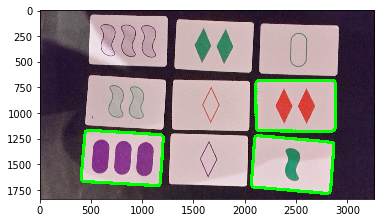

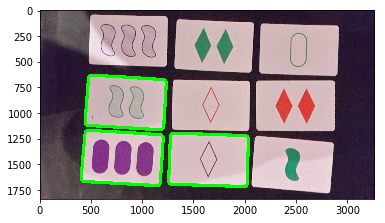

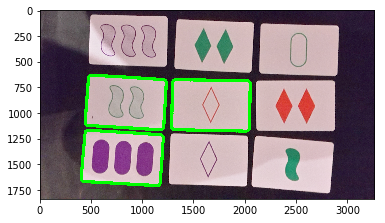

In [56]:
def getCards(im, numcards=12):
    """
    
    Fuction to get card image and information from set field image. 
    
    """
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY_INV) 


    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    #print(len(contours))

    tmp = cv2.drawContours(im.copy(), contours, -1, (0, 255, 0), 10)

    contours = sorted(contours, key=cv2.contourArea,reverse=True)[1:][:12]

    cards = []



    for card_contour in contours:


        peri = cv2.arcLength(card_contour,True)
        approx = cv2.approxPolyDP(card_contour,0.01*peri,True)
        pts = np.float32(approx)
        x,y,w,h = cv2.boundingRect(card_contour)
        average = np.sum(pts, axis=0)/len(pts)
        cent_x = int(average[0][0])
        cent_y = int(average[0][1])
        warp = transform_image(im, pts, w, h)

        cards.append([warp, card_contour])
    return cards


#Uncomment to try different image, but this one has no set. 
#im = adjust_gamma(cv2.imread("no_set_12_cards.jpg"))


#MAKE SURE TO SET THE NUMBER OF CARDS(numcards) TO 9
im = adjust_gamma(cv2.imread("set_9_cards.jpg"), 1.5)



numcards = 9
cards = getCards(im)
field = Field(im)

for card_info in cards:
    card = card_info[0]
    contour = card_info[1]
    hsv = cv2.cvtColor(card.copy(),cv2.COLOR_BGR2HSV)
    shape, number = get_shape_and_number(card)
    color, color_only = get_color(hsv, card)
        
    filling = get_filling(color_only, card)
    c = Card(shape, color, filling, number, card, contour)
    field.field.append(c)

    
field.field = field.field[:numcards]    

res = field.return_set()
for image in res: 
    show_image(image)